In [1]:
from datetime import datetime
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
# http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf
# 1x32x32 input -> (5x5),s=1,p=0 -> avg pool s=2,p=0 -> (5x5),s=1,p=0 ->
# avg pool s=2,p=0 -> Conv 5x5 to 120 channels x linear 120 -> 84 x Linear 10.
# Use ReLU instead of Tanh because ReLU wasn't invented back then.

class LeNet5(nn.Module):

  def __init__(self):
    super(LeNet5, self).__init__()

    self.feature_extractor = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2),
        nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
        nn.ReLU()
    )

    self.classifier = nn.Sequential(
        nn.Linear(in_features=120, out_features=84),
        nn.ReLU(),
        nn.Linear(in_features=84, out_features=10)
    )

  def forward(self, x):
    x = self.feature_extractor(x)
    x = torch.flatten(x, 1)
    logits = self.classifier(x)
    probs = nn.functional.softmax(logits, dim=1)
    return logits, probs



In [4]:
# Resize 28x28 MNIST data to 32x32.
tx = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])

# Download and create datasets.
train_dataset = datasets.MNIST(root='mnist', train=True, transform=tx, download=True)
valid_dataset = datasets.MNIST(root='mnist', train=False, transform=tx)

# Define data loaders.
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=32, shuffle=False)

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw




Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
model = LeNet5().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

epochs = 10
print(f'{datetime.now().time().replace(microsecond=0)} --- Start Training')
for epoch in range(epochs):
  # Train
  model.train()
  running_loss = 0
  for X, y_true in train_loader:
    optimizer.zero_grad()
    X = X.to(device)
    y_true = y_true.to(device)

    # Forward pass
    y_hat, _ = model(X)
    loss = criterion(y_hat, y_true)
    running_loss += loss.item() * X.size(0)

    # Backward pass
    loss.backward()
    optimizer.step()
  train_loss = running_loss / len(train_loader.dataset)
  # Validate
  with torch.no_grad():
    model.eval()
    running_loss = 0
    for X, y_true in valid_loader:
      X = X.to(device)
      y_true = y_true.to(device)
      y_hat, _ = model(X)
      loss = criterion(y_hat, y_true)
      running_loss += loss.item() * X.size(0)
  valid_loss = running_loss / len(valid_loader.dataset)
  print(f'{datetime.now().time().replace(microsecond=0)} --- '
        f'Epoch: {epoch}\t'
        f'Train loss: {train_loss:.4f}\t'
        f'Valid loss: {valid_loss:.4f}')



01:43:26 --- Start Training
01:43:41 --- Epoch: 0	Train loss: 0.2777	Valid loss: 0.0849
01:43:55 --- Epoch: 1	Train loss: 0.0776	Valid loss: 0.0584
01:44:09 --- Epoch: 2	Train loss: 0.0556	Valid loss: 0.0396
01:44:23 --- Epoch: 3	Train loss: 0.0424	Valid loss: 0.0431
01:44:38 --- Epoch: 4	Train loss: 0.0356	Valid loss: 0.0359
01:44:52 --- Epoch: 5	Train loss: 0.0300	Valid loss: 0.0396
01:45:06 --- Epoch: 6	Train loss: 0.0232	Valid loss: 0.0335
01:45:20 --- Epoch: 7	Train loss: 0.0218	Valid loss: 0.0332
01:45:34 --- Epoch: 8	Train loss: 0.0193	Valid loss: 0.0381
01:45:49 --- Epoch: 9	Train loss: 0.0153	Valid loss: 0.0470


Text(0.5, 0.98, 'LeNet-5 Predictions')

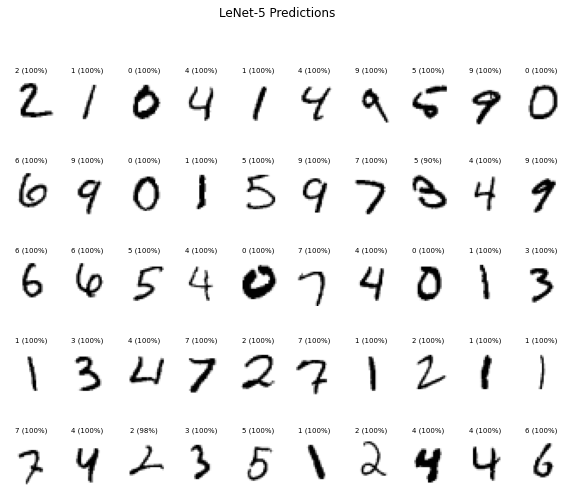

In [14]:
# Plot some predictions
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(10,8))
IMG_PER_ROW = 10
ROWS = 5

for idx in range(1, ROWS * IMG_PER_ROW + 1):
  plt.subplot(ROWS, IMG_PER_ROW, idx)
  plt.axis('off')
  plt.imshow(valid_dataset.data[idx], cmap='gray_r')

  with torch.no_grad():
    model.eval()
    _, probs = model(valid_dataset[idx][0].unsqueeze(0).to(device))
  title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
  plt.title(title, fontsize=7)
fig.suptitle('LeNet-5 Predictions')